<a href="https://colab.research.google.com/github/oscar0325/temporal_geometric_deep_learning/blob/main/a3tgch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 扩展库安装

In [9]:
torch.__version__

'1.12.0+cu113'

In [3]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.12.0+cu113.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.12.0+cu113.html
!pip install torch-geometric
!pip install torch-geometric-temporal
!pip install torch-geometric-temporal --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.0+cu113.html
     |████████████████████████████████| 7.9 MB 9.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.0+cu113.html
     |████████████████████████████████| 3.5 MB 8.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 407 kB 7.8 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.4-py3-none-any.whl size=616603 sha256=4df307c4f1c29ef72a606d7ccd5f4f43acb8f875380567ec49b036ea81a02aa3
  Stored in directory: /root/.cache/pip/wheels/18/a6/a4/ca18c3051fcead866fe7b85700ee2240d883562a1bc70ce421
Successfully built torch-geometric
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/pub

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric_temporal.nn.recurrent import A3TGCN2
from torch_geometric_temporal.signal import temporal_signal_split

# GPU support
DEVICE = torch.device('cuda') # cuda
shuffle=True
batch_size = 32

# A3T-GCN: Attention Temporal Graph Convolutional Network for Traffic Forecasting

## 1.数据集
* 洛杉矶交通状况数据
* 通过207个高速公路上的检测器采集
* 采集时间：2012年3月至2012年6月

检测器分布图：

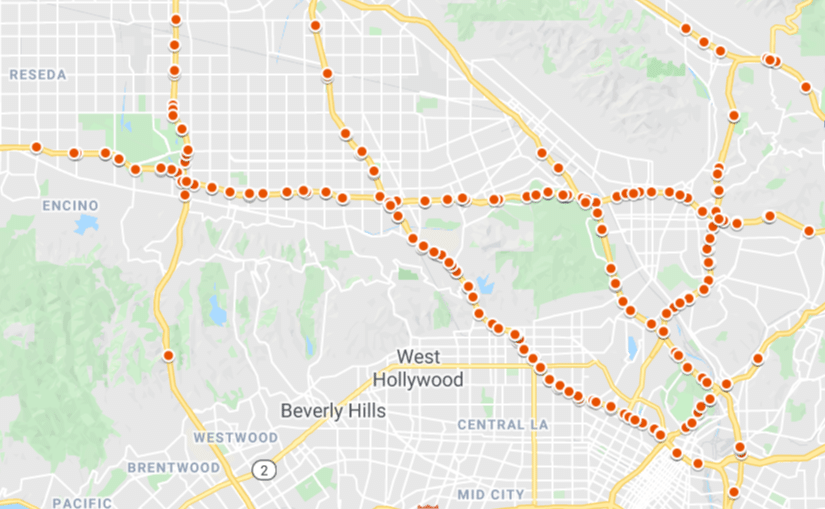

In [5]:
from torch_geometric_temporal.dataset import METRLADatasetLoader
loader = METRLADatasetLoader()
dataset = loader.get_dataset(num_timesteps_in=12, num_timesteps_out=12)
print("Dataset type:  ", dataset)
print("Number of samples / sequences: ",  len(set(dataset)))
print(next(iter(dataset))) # Show first sample

Dataset type:   <torch_geometric_temporal.signal.static_graph_temporal_signal.StaticGraphTemporalSignal object at 0x7fbcc43fb910>
Number of samples / sequences:  34249
Data(x=[207, 2, 12], edge_index=[2, 1722], edge_attr=[1722], y=[207, 12])


## 2.数据样本
* 207个节点
* 每个节点两个特征值(车辆速度，时间）
* 每5分钟收集一次数据
* 标签y为后续12个时间步长的车辆速度
* Edge_attr为邻接矩阵中边的权重，生成方法为：根据各检测器之间的距离，使用thresholded Gaussian kernel计算生成权重。公式如下：$$W_{ij}=exp(-\frac{dist(v_{i},v_{j})^2}{σ^2})\quad if\quad dist(v_{i},v_{j})≤k, otherwise\quad0$$
其中，$W_{ij}$表示节点$v_i$、$v_j$之间的权重，$dist(v_i,v_j)$表示${v_i}$和${v_j}$之间的距离，$\sigma$为距离的标准差，$k$为阈值。 


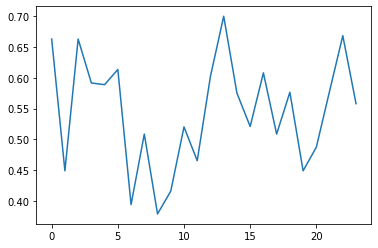

In [6]:
# 一个节点的24个小时数据的可视化
sensor_number = 1
hours = 24
sensor_labels = [bucket.y[sensor_number][0].item() for bucket in list(dataset)[:hours]]
plt.plot(sensor_labels)

## 3.数据集划分

In [7]:
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

print("Number of train buckets: ", len(set(train_dataset)))
print("Number of test buckets: ", len(set(test_dataset)))

Number of train buckets:  27399
Number of test buckets:  6850


## 4.生成DataLoaders

In [8]:
train_input = np.array(train_dataset.features) # (27399, 207, 2, 12)
train_target = np.array(train_dataset.targets) # (27399, 207, 12)
train_x_tensor = torch.from_numpy(train_input).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
train_target_tensor = torch.from_numpy(train_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
train_dataset_new = torch.utils.data.TensorDataset(train_x_tensor, train_target_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset_new, batch_size=batch_size, shuffle=shuffle,drop_last=True)

In [10]:
test_input = np.array(test_dataset.features) # (, 207, 2, 12)
test_target = np.array(test_dataset.targets) # (, 207, 12)
test_x_tensor = torch.from_numpy(test_input).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
test_target_tensor = torch.from_numpy(test_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
test_dataset_new = torch.utils.data.TensorDataset(test_x_tensor, test_target_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset_new, batch_size=batch_size, shuffle=shuffle,drop_last=True)

## 5.模型
1. TGCN(Temporal GCN):由GCN和GRU组合构成，输入n个时间步长的流量序列（$X_{t-n},...,X_t)$，生成n个隐藏状态$(h_{t-n},...,h_{t})$来表示时空特征。$$u_t=\sigma(W_u*(GC(A,X_t), h_{t-1}))$$
$$r_t=\sigma(W_r*(GC(A,X_t),h_{t-1}$$
$$c_t=tanh(W_c*(GC(A,X_t),(r_t*h_{t-1}))$$
$$h_t=u_t*h_{t-1}+(1-u_t)*c_t$$
2. A3TGCN:增加了注意力机制，将隐藏状态输入软注意力模块中，调整各时间点隐藏状态的权重后，进行加权计算后输出结果

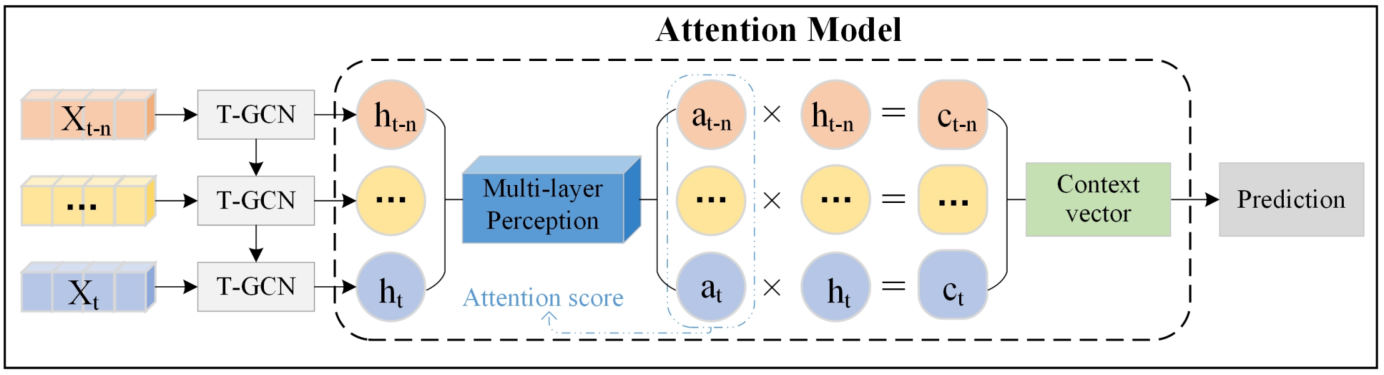


In [12]:
class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, periods, batch_size):
        super(TemporalGNN, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        self.tgnn = A3TGCN2(in_channels=node_features,  out_channels=32, periods=periods,batch_size=batch_size) # node_features=2, periods=12
        # Equals single-shot prediction
        self.linear = torch.nn.Linear(32, periods)

    def forward(self, x, edge_index):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        h = self.tgnn(x, edge_index) # x [b, 207, 2, 12]  returns h [b, 207, 12]
        h = F.relu(h) 
        h = self.linear(h)
        return h

TemporalGNN(node_features=2, periods=12, batch_size=2)

TemporalGNN(
  (tgnn): A3TGCN2(
    (_base_tgcn): TGCN2(
      (conv_z): GCNConv(2, 32)
      (linear_z): Linear(in_features=64, out_features=32, bias=True)
      (conv_r): GCNConv(2, 32)
      (linear_r): Linear(in_features=64, out_features=32, bias=True)
      (conv_h): GCNConv(2, 32)
      (linear_h): Linear(in_features=64, out_features=32, bias=True)
    )
  )
  (linear): Linear(in_features=32, out_features=12, bias=True)
)

## 6.训练

In [13]:
# Create model and optimizers
model = TemporalGNN(node_features=2, periods=12, batch_size=batch_size).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()


print('Net\'s state_dict:')
total_param = 0
for param_tensor in model.state_dict():
    print(param_tensor, '\t', model.state_dict()[param_tensor].size())
    total_param += np.prod(model.state_dict()[param_tensor].size())
print('Net\'s total params:', total_param)
#--------------------------------------------------
print('Optimizer\'s state_dict:')
for var_name in optimizer.state_dict():
    print(var_name, '\t', optimizer.state_dict()[var_name])

Net's state_dict:
tgnn._attention 	 torch.Size([12])
tgnn._base_tgcn.conv_z.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_z.lin.weight 	 torch.Size([32, 2])
tgnn._base_tgcn.linear_z.weight 	 torch.Size([32, 64])
tgnn._base_tgcn.linear_z.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_r.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_r.lin.weight 	 torch.Size([32, 2])
tgnn._base_tgcn.linear_r.weight 	 torch.Size([32, 64])
tgnn._base_tgcn.linear_r.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_h.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_h.lin.weight 	 torch.Size([32, 2])
tgnn._base_tgcn.linear_h.weight 	 torch.Size([32, 64])
tgnn._base_tgcn.linear_h.bias 	 torch.Size([32])
linear.weight 	 torch.Size([12, 32])
linear.bias 	 torch.Size([12])
Net's total params: 6936
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'maximize': False, 'foreach': None, 'capturable': False, 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8,

## 7.加载图的邻接矩阵

In [15]:
for snapshot in train_dataset:
    static_edge_index = snapshot.edge_index.to(DEVICE)
    break;

In [16]:
model.train()

for epoch in range(1):
    step = 0
    loss_list = []
    for encoder_inputs, labels in train_loader:
        y_hat = model(encoder_inputs, static_edge_index)         # Get model predictions
        loss = loss_fn(y_hat, labels) # Mean squared error #loss = torch.mean((y_hat-labels)**2)  sqrt to change it to rmse
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        step= step+ 1
        loss_list.append(loss.item())
        if step % 100 == 0 :
            print(sum(loss_list)/len(loss_list))
    print("Epoch {} train RMSE: {:.4f}".format(epoch, sum(loss_list)/len(loss_list)))

0.7329568985104561
0.6359485740959644
0.5869338338573774
0.5599864563345909
0.5468229068517685
0.5358822073539098
0.5273284274765423
0.5199971091747284
Epoch 0 train RMSE: 0.5167


## 8.预测
### 通过上一个小时的数据，预测下一个小时

In [ ]:
model.eval()
step = 0
# Store for analysis
total_loss = []
for encoder_inputs, labels in test_loader:
    # Get model predictions
    y_hat = model(encoder_inputs, static_edge_index)
    # Mean squared error
    loss = loss_fn(y_hat, labels)
    total_loss.append(loss.item())
    # Store for analysis below
    #test_labels.append(labels)
    #predictions.append(y_hat)
    

print("Test MSE: {:.4f}".format(sum(total_loss)/len(total_loss)))

## 9.预测结果可视化

In [19]:
sensor = 123
timestep = 11 
preds = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in y_hat])
labs  = np.asarray([label[sensor][timestep].cpu().numpy() for label in labels])
print("Data points:,", preds.shape)

Data points:, (32,)


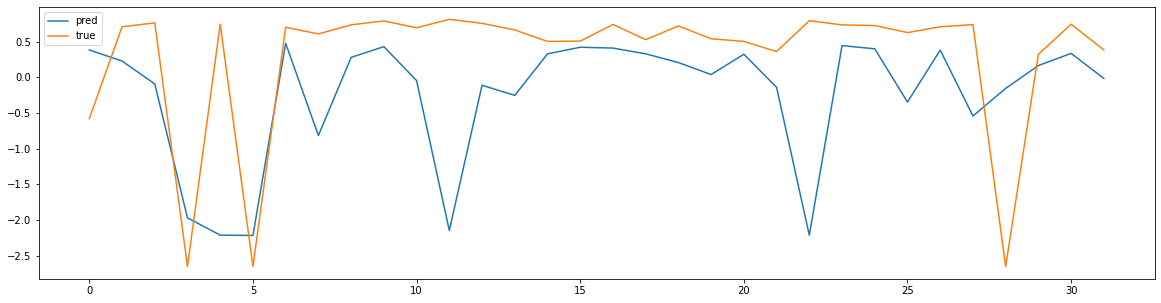

In [20]:
plt.figure(figsize=(20,5))
sns.lineplot(data=preds, label="pred")
sns.lineplot(data=labs, label="true")